In [48]:
import pandas as pd
import numpy as np
import os
from datetime import datetime,date,timedelta
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.exceptions import NotFound
from google.api_core.exceptions import BadRequest

In [61]:
start_date='2023-05-01'
date_col='prediction_date'
AssetName='SPY'


json_credential_file=r'C:\Windows\pongthorn-5decdc5124f5.json'
projectId='pongthorn'
dataset_id='FinAssetForecast'

In [62]:
table_data_id=f"{projectId}.{dataset_id}.fin_data"
table_id = f"{projectId}.{dataset_id}.fin_movement_forecast"
print(table_id)
print(table_data_id)


credentials = service_account.Credentials.from_service_account_file(json_credential_file)
client = bigquery.Client(project=projectId,credentials=credentials )

pongthorn.FinAssetForecast.fin_movement_forecast
pongthorn.FinAssetForecast.fin_data


In [63]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df

# Load all field
# sql=f"""
# select t.prediction_date, t.prediction_name, t.asset_name,t.pred_timestamp,t.feature_for_prediction,t.prediction_result
# from `{table_id}`  t
# inner join (
#  select prediction_date, max(pred_timestamp) as MaxDate
#     from  `{table_id}` 
#     group by prediction_date 
#   ) tm on t.prediction_date = tm.prediction_date and t.pred_timestamp = tm.MaxDate
#   where t.prediction_date>='{start_date}'
#   order by t.prediction_date  

# """
# print(sql)
# df=load_data_bq(sql)
# df[date_col]=pd.to_datetime(df[date_col],format='%Y-%m-%d')


# print(df.info())
# df.head()
# # print(df.tail())

# How far back in time does model want to apply as input to make prediction

In [64]:
sqlInput=f"""
select t_feature.input_date as x_date,t_feature.input_feature x_ema1
from  `pongthorn.FinAssetForecast.fin_movement_forecast` t
cross join unnest(t.feature_for_prediction) t_feature
where t.prediction_date='{start_date}'
"""

dfInput=load_data_bq(sqlInput)
dfInput['x_date']=pd.to_datetime(dfInput['x_date'],format='%Y-%m-%d')
dfInput.set_index('x_date',inplace=True)
input_sequence_length=len(dfInput)
dfInput.info()
dfInput.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2023-02-03 to 2023-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_ema1  60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


,x_ema1
x_date,
2023-04-25,410.6558
2023-04-26,409.5111
2023-04-27,410.0382
2023-04-28,411.1094
2023-05-01,411.9095


# How far in advance does model want to  make prediction

In [65]:
sqlOutput=f"""
select t_pred.output_date as x_date,t_pred.output_value x_ema1
from  `pongthorn.FinAssetForecast.fin_movement_forecast` t
cross join unnest(t.prediction_result) t_pred
where t.prediction_date='{start_date}'
"""
dfOutput=load_data_bq(sqlOutput)
output_sequence_length=len(dfOutput)
dfOutput['x_date']=pd.to_datetime(dfOutput['x_date'],format='%Y-%m-%d')
dfOutput.set_index('x_date',inplace=True)
dfOutput.info()
dfOutput

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2023-05-02 to 2023-05-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_ema1  10 non-null     float64
dtypes: float64(1)
memory usage: 160.0 bytes


,x_ema1
x_date,
2023-05-02,415.288513
2023-05-03,412.633087
2023-05-04,413.647980
2023-05-05,413.049194
2023-05-08,417.591766
2023-05-09,415.011688
2023-05-10,414.955322
2023-05-11,416.082550
2023-05-12,415.974609


# Get Real Data  to compare to prediction

In [66]:
startFinData=dfInput.index.min().strftime('%Y-%m-%d')
endFindData=dfOutput.index.max().strftime('%Y-%m-%d')

sqlData=f"""
select Date as x_date,EMA1 as ema1, from `{table_data_id}` where Date>='{startFinData}' and Date<='{endFindData}'
order by Date
"""
print(sqlData)

dfRealData=load_data_bq(sqlData)
dfRealData['x_date']=pd.to_datetime(dfRealData['x_date'],format='%Y-%m-%d')
dfRealData.set_index('x_date',inplace=True)
dfRealData.info()
dfRealData


select Date as x_date,EMA1 as ema1, from `pongthorn.FinAssetForecast.fin_data` where Date>='2023-02-03' and Date<='2023-05-15'
order by Date

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2023-02-03 to 2023-05-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ema1    70 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


,ema1
x_date,
2023-02-03,406.3481
2023-02-06,406.9812
2023-02-07,408.4737
2023-02-08,408.8694
2023-02-09,408.5459
...,...
2023-05-09,410.8793
2023-05-10,411.2376
2023-05-11,411.3999


# Visualize Prediction Result

<Axes: title={'center': 'SPY - 60 days ago to predict next 10 days'}, xlabel='x_date', ylabel='ema1'>

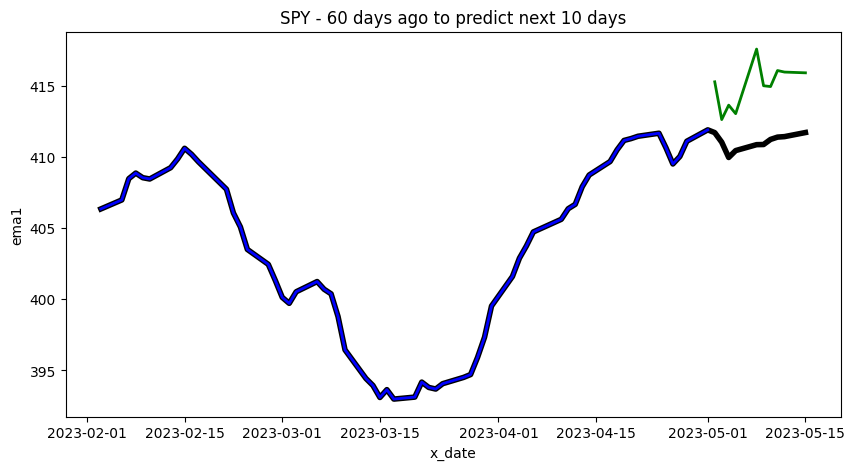

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title(f"{AssetName} - {input_sequence_length} days ago to predict next {output_sequence_length} days", fontsize=12)
sns.lineplot(data = dfRealData['ema1'], linewidth=4.0,  markers='o',ax=ax,color='black')
sns.lineplot(data = dfInput['x_ema1'], linewidth=2.0, ax=ax,color='blue')
sns.lineplot(data = dfOutput['x_ema1'], linewidth=2.0, ax=ax,color='green')